In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
from keras.utils import to_categorical
from keras import callbacks
from sklearn.metrics import precision_score, recall_score, confusion_matrix,ConfusionMatrixDisplay ,classification_report, accuracy_score, f1_score
from sklearn.utils import class_weight

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2025-05-09 21:37:25.391776: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746826645.684894      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746826645.767506      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/heart-failure-clinical-data/heart_failure_clinical_records_dataset.csv


In [3]:
df=pd.read_csv('/kaggle/input/heart-failure-clinical-data/heart_failure_clinical_records_dataset.csv')

In [4]:
df.head(10)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
5,90.0,1,47,0,40,1,204000.00,2.1,132,1,1,8,1
6,75.0,1,246,0,15,0,127000.00,1.2,137,1,0,10,1
7,60.0,1,315,1,60,0,454000.00,1.1,131,1,1,10,1
8,65.0,0,157,0,65,0,263358.03,1.5,138,0,0,10,1
9,80.0,1,123,0,35,1,388000.00,9.4,133,1,1,10,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


<Axes: xlabel='DEATH_EVENT', ylabel='count'>

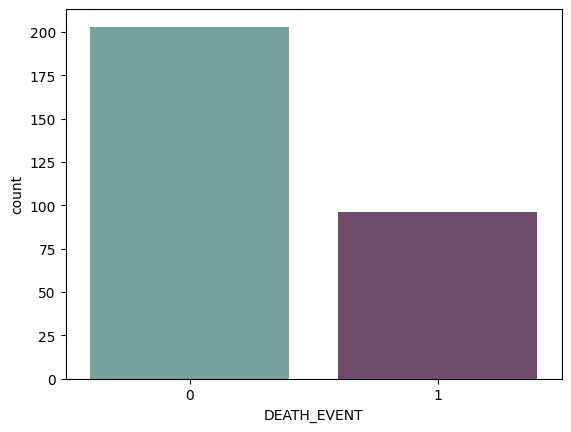

In [6]:
#first of all let us evaluate the target and find out if our data is imbalanced or not
cols= ["#6daa9f","#774571"]
sns.countplot(x= df["DEATH_EVENT"], palette= cols)

In [7]:
df['DEATH_EVENT'].value_counts()

DEATH_EVENT
0    203
1     96
Name: count, dtype: int64

<Axes: >

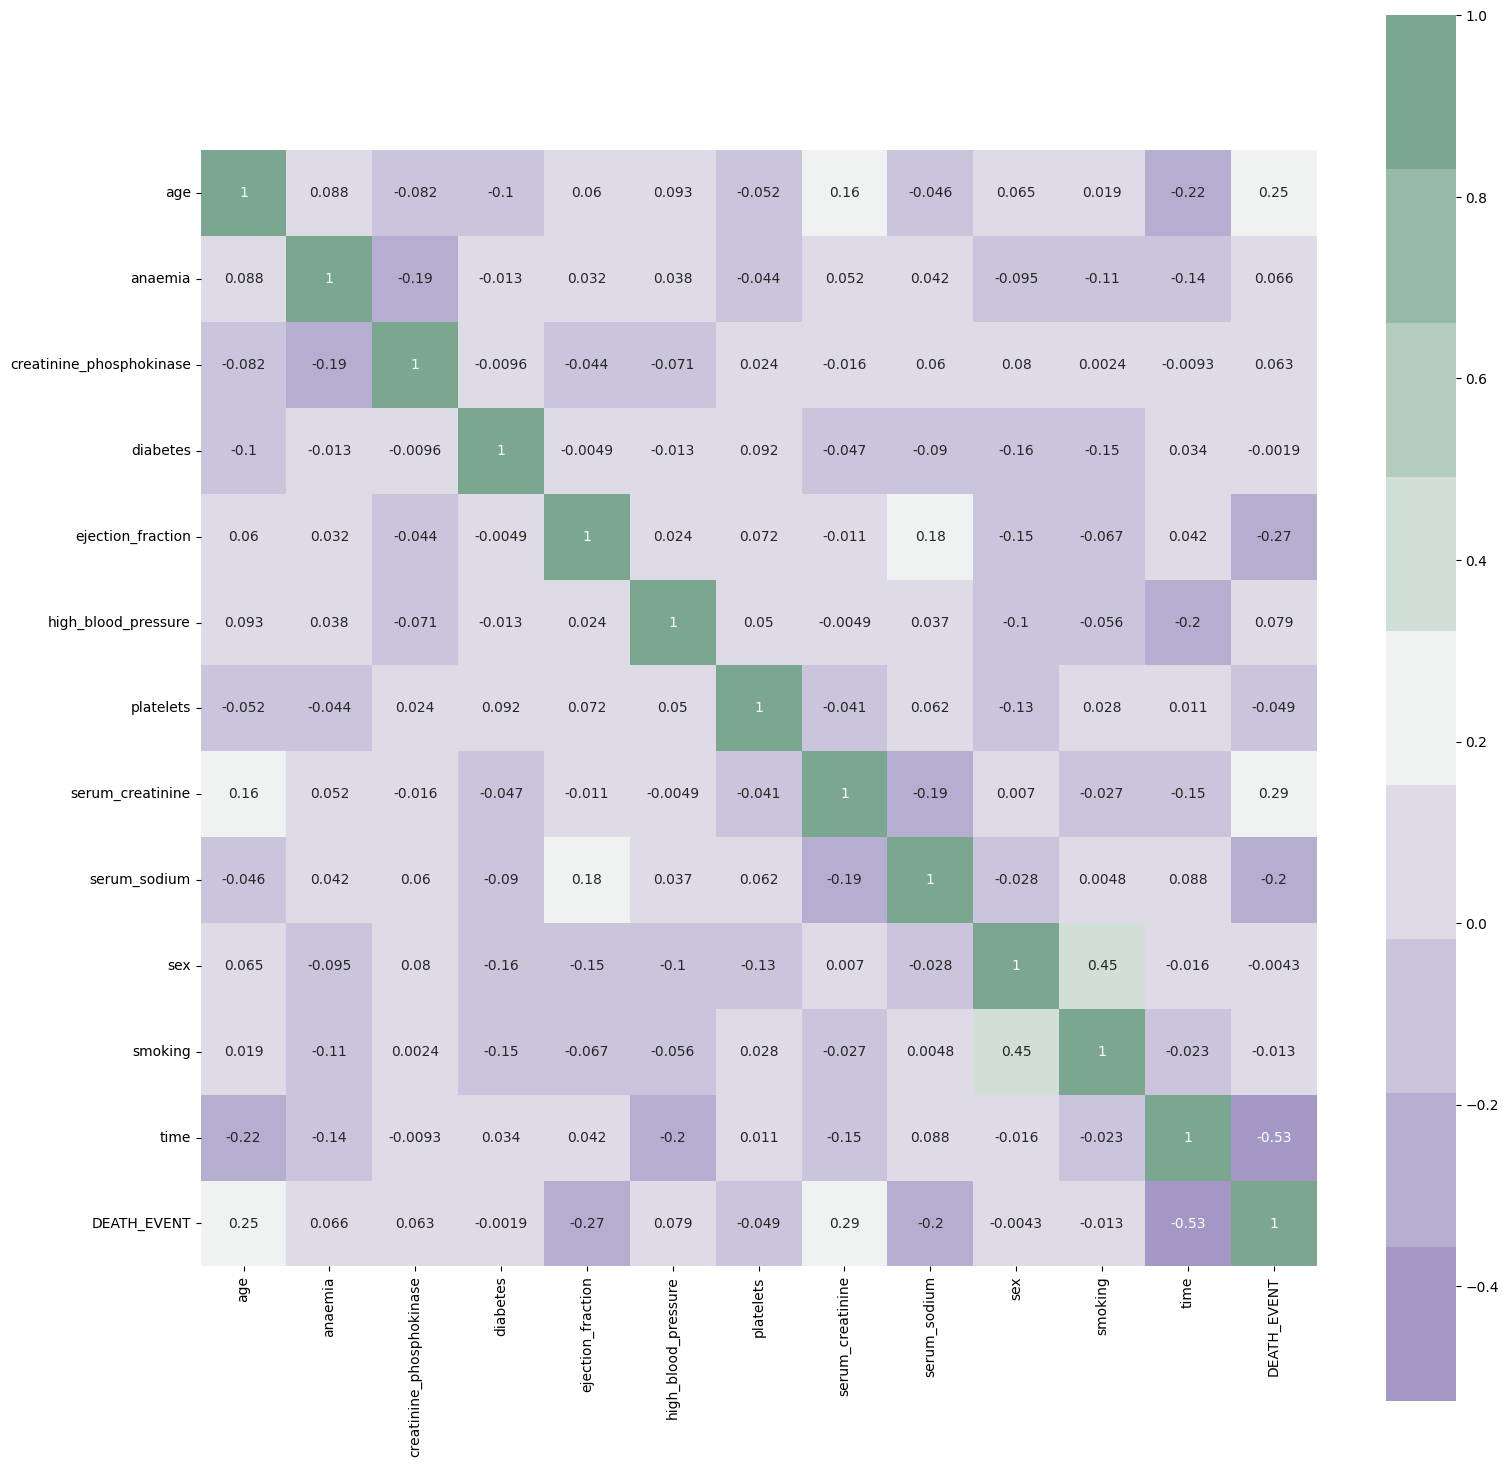

In [8]:
#correlation of all features
cmap=sns.diverging_palette(275,150,s=40,l=65,n=9)
corrmat=df.corr()
plt.subplots(figsize=(18,18))
sns.heatmap(corrmat,cmap= cmap,annot=True,square=True)

Text(0.5, 1.0, 'Distribution Of Age')

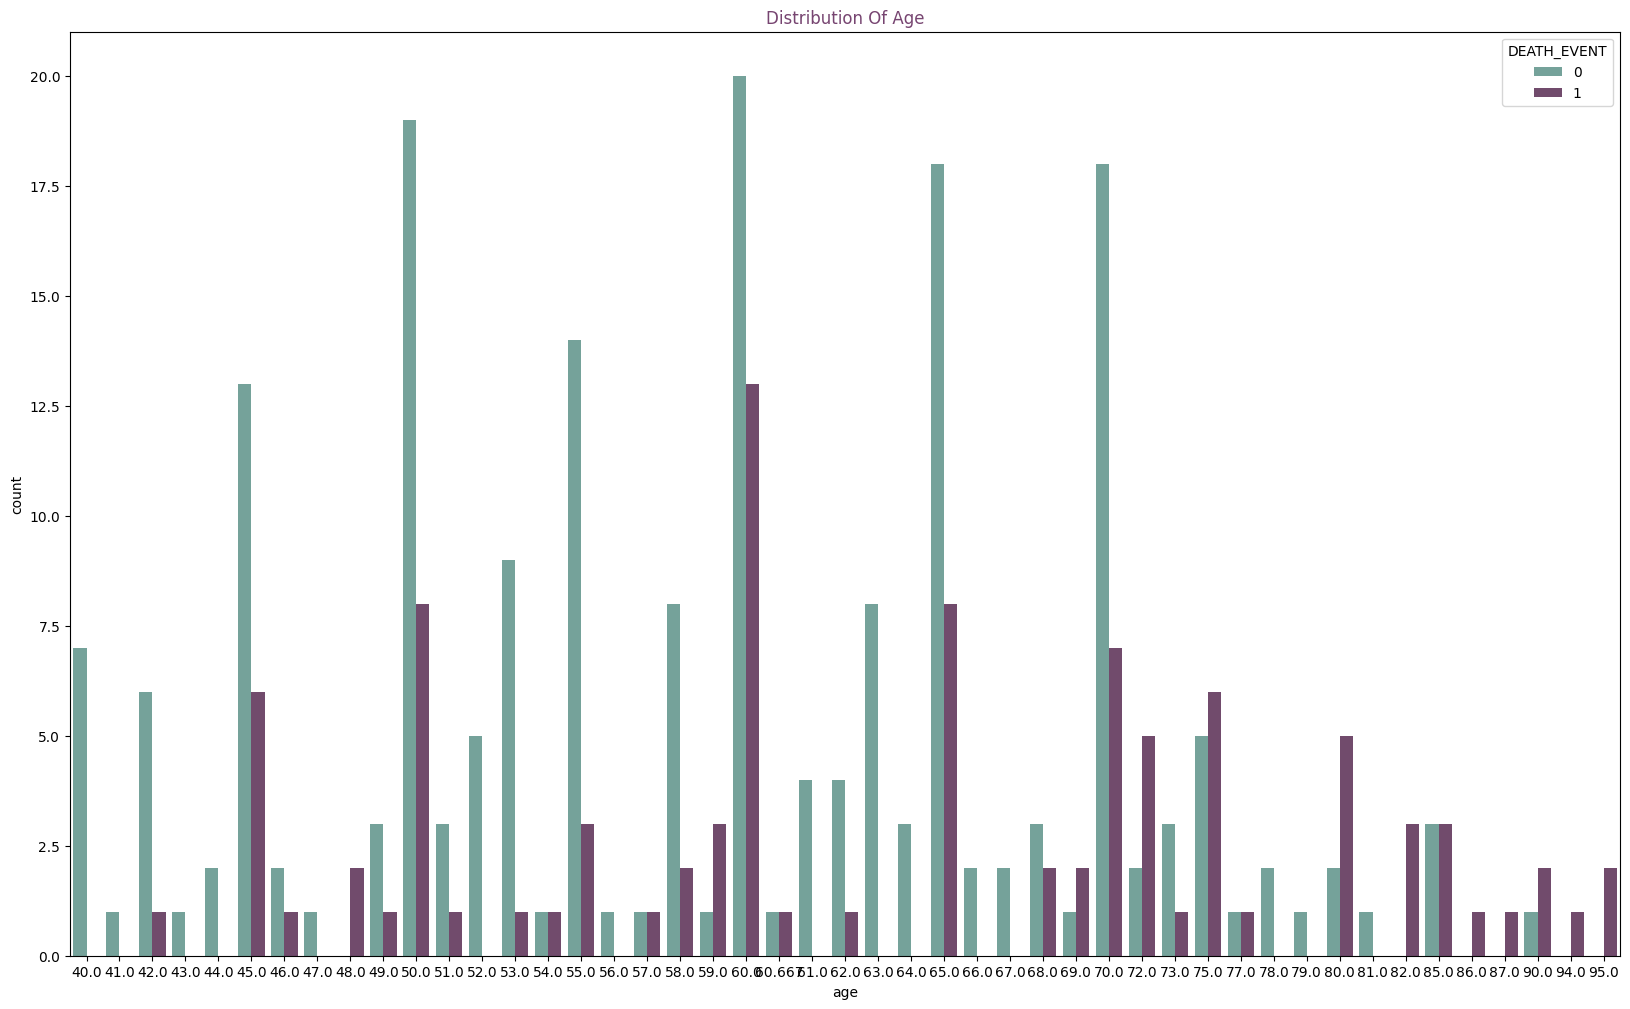

In [9]:
#Evauating age distrivution 
plt.figure(figsize=(20,12))
#colours =["#774571","#b398af","#f1f1f1" ,"#afcdc7", "#6daa9f"]
Days_of_week=sns.countplot(x=df['age'],data=df, hue ="DEATH_EVENT",palette = cols)
Days_of_week.set_title("Distribution Of Age", color="#774571")

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conv

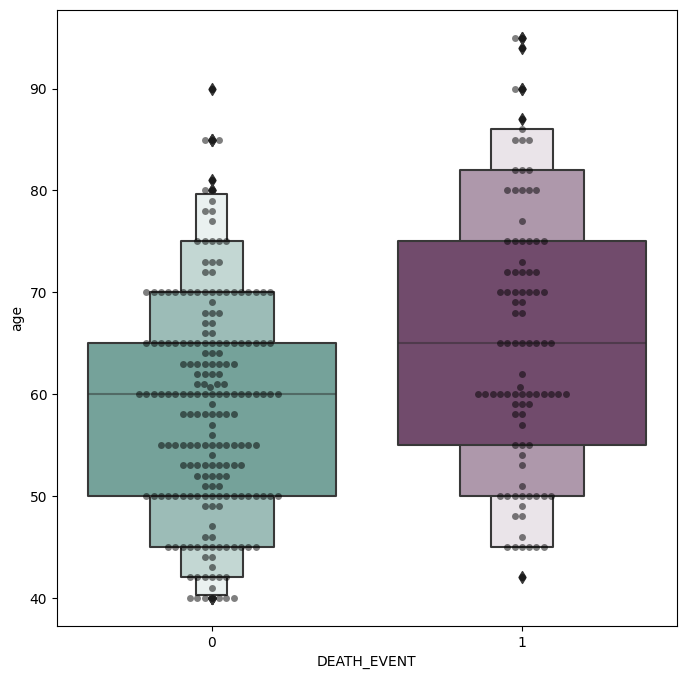

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conv

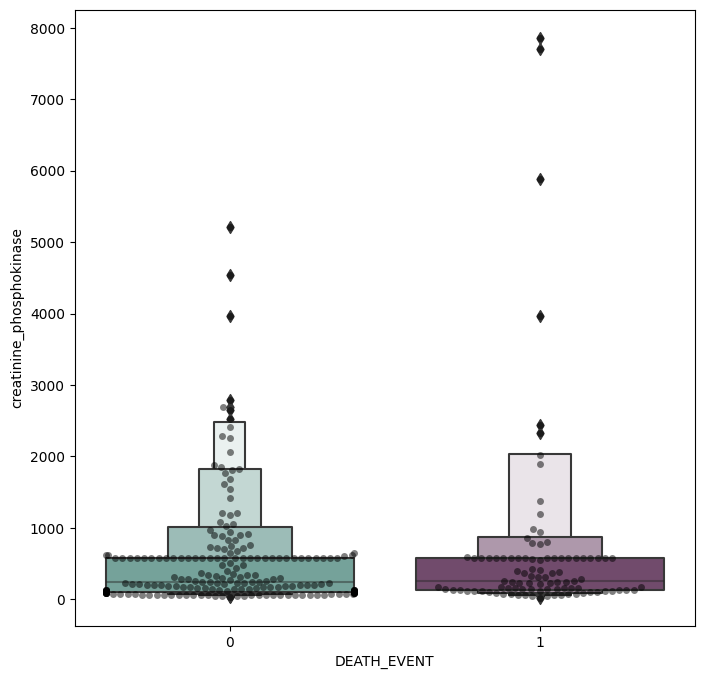

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conv

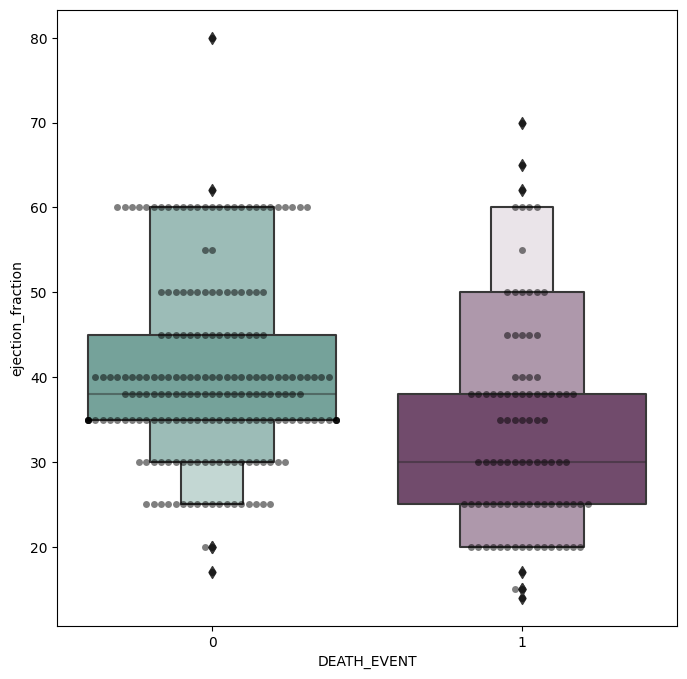

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conv

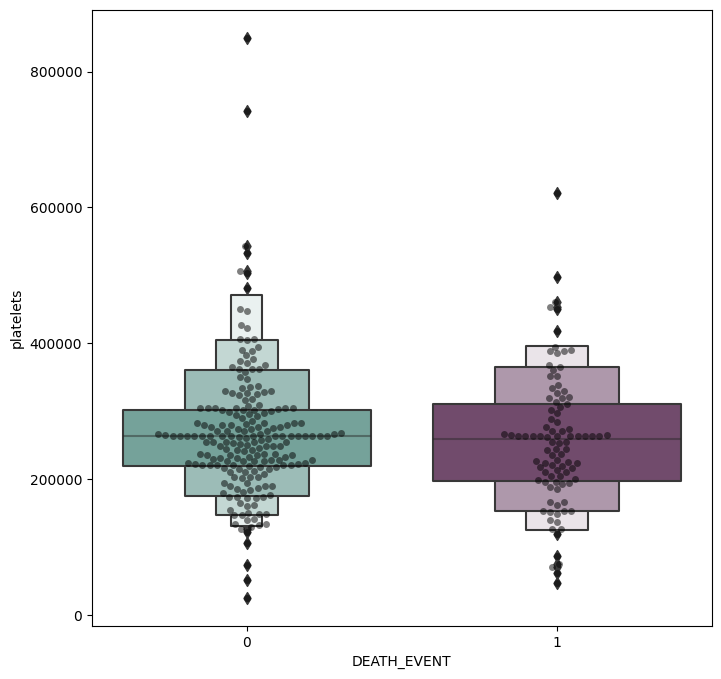

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conv

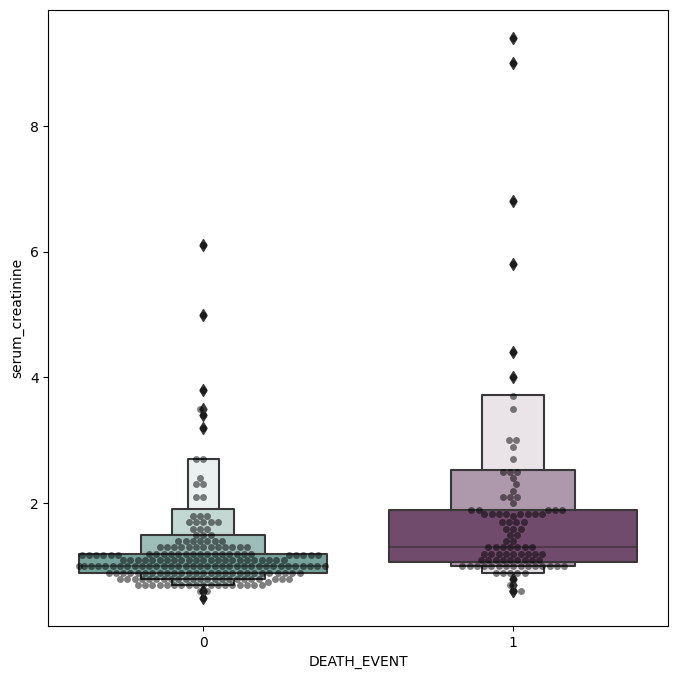

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conv

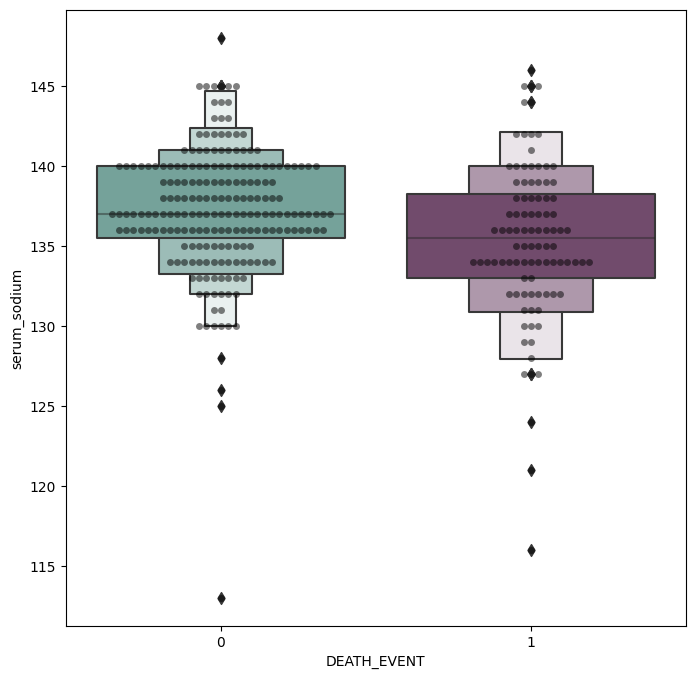

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conv

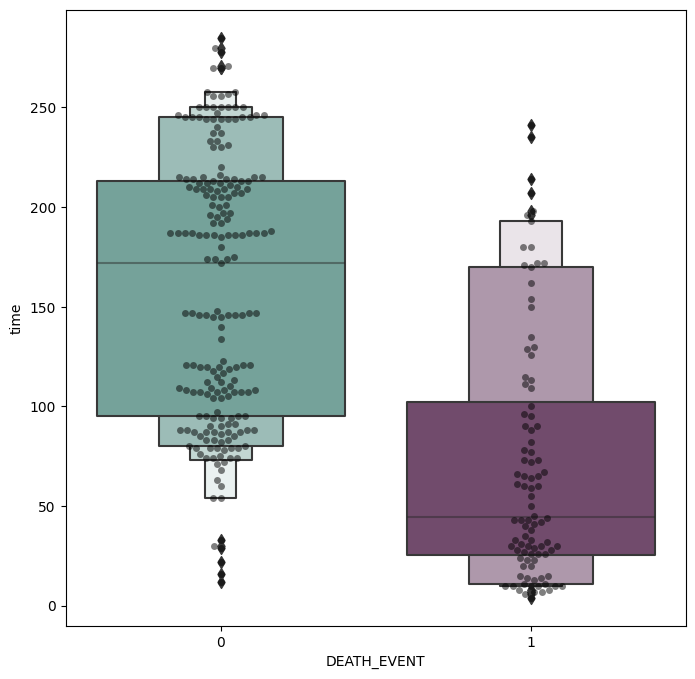

In [10]:
#boxen and swarm plot of some non binary features
feature=["age","creatinine_phosphokinase","ejection_fraction","platelets","serum_creatinine","serum_sodium", "time"]
for i in feature:
    plt.figure(figsize=(8,8))
    sns.swarmplot(x=df["DEATH_EVENT"],y=df[i],color="black",alpha=0.5)
    sns.boxenplot(x=df["DEATH_EVENT"],y=df[i],palette=cols)
    plt.show()

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,299.0,60.833893,11.894809,40.0,51.0,60.0,70.0,95.0
anaemia,299.0,0.431438,0.496107,0.0,0.0,0.0,1.0,1.0
creatinine_phosphokinase,299.0,581.839465,970.287881,23.0,116.5,250.0,582.0,7861.0
diabetes,299.0,0.418060,0.494067,0.0,0.0,0.0,1.0,1.0
ejection_fraction,299.0,38.083612,11.834841,14.0,30.0,38.0,45.0,80.0
high_blood_pressure,299.0,0.351171,0.478136,0.0,0.0,0.0,1.0,1.0
platelets,299.0,263358.029264,97804.236869,25100.0,212500.0,262000.0,303500.0,850000.0
serum_creatinine,299.0,1.393880,1.034510,0.5,0.9,1.1,1.4,9.4
serum_sodium,299.0,136.625418,4.412477,113.0,134.0,137.0,140.0,148.0
sex,299.0,0.648829,0.478136,0.0,0.0,1.0,1.0,1.0


In [12]:
df.isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

**DATA PREPROCESSING**

In [13]:
#SCALING
scaler=StandardScaler()
X=scaler.fit_transform(df.drop('DEATH_EVENT',axis=1))
y=df['DEATH_EVENT'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=7)

In [14]:
#assigning values to features as X and target as y
X=df.drop(["DEATH_EVENT"],axis=1)
y=df["DEATH_EVENT"]

In [15]:
#Set up a standard scaler for the features
col_names = list(X.columns)
s_scaler = preprocessing.StandardScaler()
X_df= s_scaler.fit_transform(X)
X_df = pd.DataFrame(X_df, columns=col_names)   
X_df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,299.0,5.703353e-16,1.001676,-1.754448,-0.828124,-0.070223,0.771889,2.877170
anaemia,299.0,9.505588e-17,1.001676,-0.871105,-0.871105,-0.871105,1.147968,1.147968
creatinine_phosphokinase,299.0,-1.039674e-17,1.001676,-0.576918,-0.480393,-0.342574,0.000166,7.514640
diabetes,299.0,9.060014e-17,1.001676,-0.847579,-0.847579,-0.847579,1.179830,1.179830
ejection_fraction,299.0,-1.485248e-18,1.001676,-2.038387,-0.684180,-0.007077,0.585389,3.547716
high_blood_pressure,299.0,0.000000e+00,1.001676,-0.735688,-0.735688,-0.735688,1.359272,1.359272
platelets,299.0,7.426241e-17,1.001676,-2.440155,-0.520870,-0.013908,0.411120,6.008180
serum_creatinine,299.0,1.425838e-16,1.001676,-0.865509,-0.478205,-0.284552,0.005926,7.752020
serum_sodium,299.0,-8.733259e-16,1.001676,-5.363206,-0.595996,0.085034,0.766064,2.582144
sex,299.0,-8.911489e-18,1.001676,-1.359272,-1.359272,0.735688,0.735688,0.735688


/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

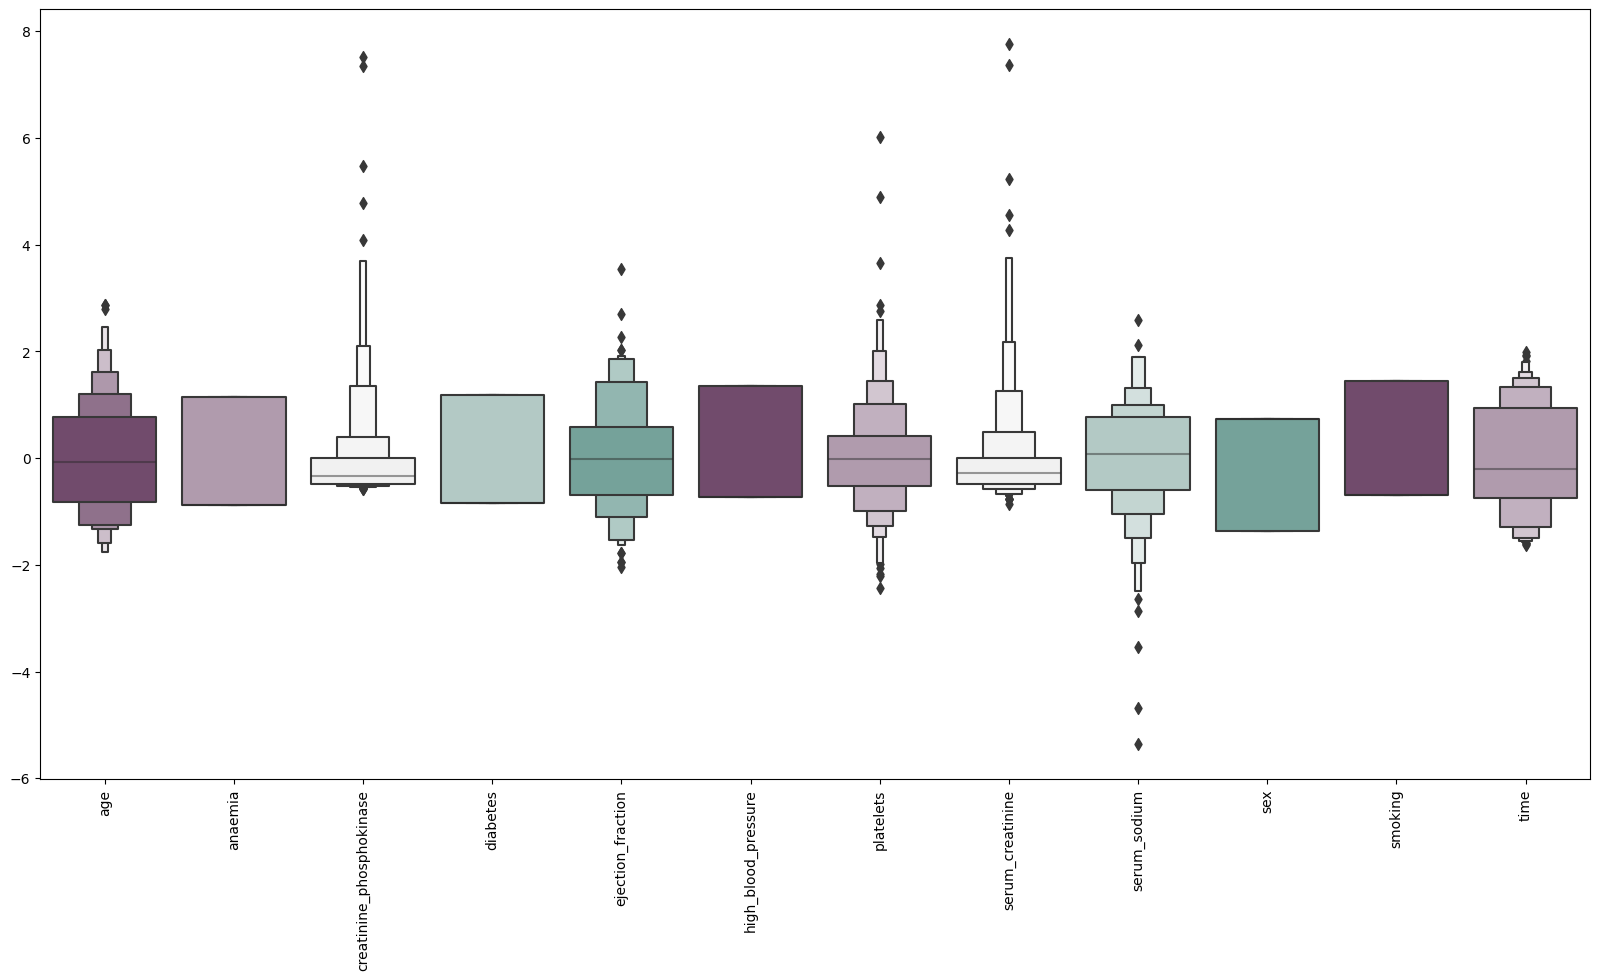

In [16]:
#looking at the scaled features
colours =["#774571","#b398af","#f1f1f1" ,"#afcdc7", "#6daa9f"]
plt.figure(figsize=(20,10))
sns.boxenplot(data = X_df,palette = colours)
plt.xticks(rotation=90)
plt.show()

In [17]:
#spliting test and training sets
X_train, X_test, y_train, y_test = train_test_split(X_df,y,test_size=0.25,random_state=7)

In [18]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [19]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Lasso (Logistic L1)': LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000),
    'Ridge (Logistic L2)': LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'SVM': SVC(),
    'Naive Bayes': GaussianNB(),
}

In [20]:
results = {}

for name, model in models.items():
   
    model.fit(X_train,y_train)
    y_pred= model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    print("*********************************************************\n")

Logistic Regression Accuracy: 0.8267
              precision    recall  f1-score   support

           0       0.89      0.88      0.88        57
           1       0.63      0.67      0.65        18

    accuracy                           0.83        75
   macro avg       0.76      0.77      0.77        75
weighted avg       0.83      0.83      0.83        75

*********************************************************

Lasso (Logistic L1) Accuracy: 0.8400
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        57
           1       0.67      0.67      0.67        18

    accuracy                           0.84        75
   macro avg       0.78      0.78      0.78        75
weighted avg       0.84      0.84      0.84        75

*********************************************************

Ridge (Logistic L2) Accuracy: 0.8267
              precision    recall  f1-score   support

           0       0.89      0.88      0.88        57
        


Logistic Regression Accuracy: 0.8267
              precision    recall  f1-score   support

           0       0.89      0.88      0.88        57
           1       0.63      0.67      0.65        18

    accuracy                           0.83        75
   macro avg       0.76      0.77      0.77        75
weighted avg       0.83      0.83      0.83        75



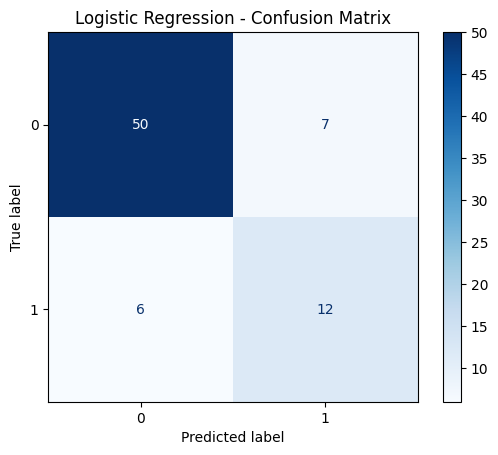


Lasso (Logistic L1) Accuracy: 0.8400
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        57
           1       0.67      0.67      0.67        18

    accuracy                           0.84        75
   macro avg       0.78      0.78      0.78        75
weighted avg       0.84      0.84      0.84        75



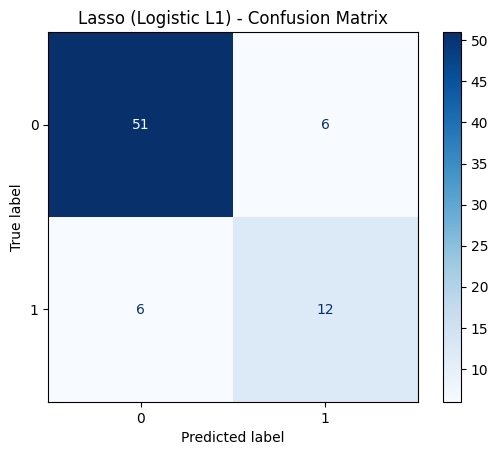


Ridge (Logistic L2) Accuracy: 0.8267
              precision    recall  f1-score   support

           0       0.89      0.88      0.88        57
           1       0.63      0.67      0.65        18

    accuracy                           0.83        75
   macro avg       0.76      0.77      0.77        75
weighted avg       0.83      0.83      0.83        75



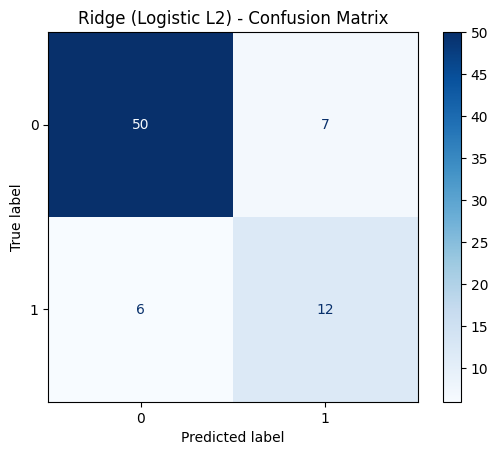


KNN Accuracy: 0.7600
              precision    recall  f1-score   support

           0       0.82      0.88      0.85        57
           1       0.50      0.39      0.44        18

    accuracy                           0.76        75
   macro avg       0.66      0.63      0.64        75
weighted avg       0.74      0.76      0.75        75



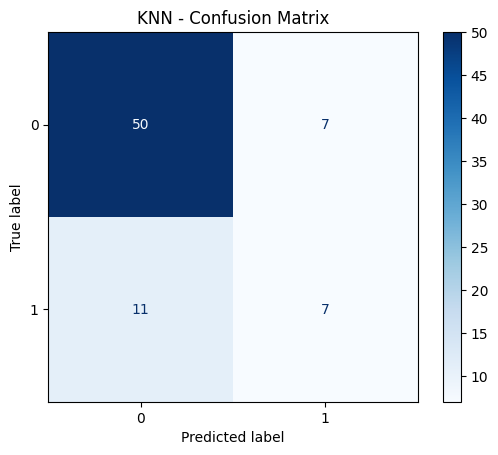


Random Forest Accuracy: 0.9067
              precision    recall  f1-score   support

           0       0.92      0.96      0.94        57
           1       0.87      0.72      0.79        18

    accuracy                           0.91        75
   macro avg       0.89      0.84      0.86        75
weighted avg       0.90      0.91      0.90        75



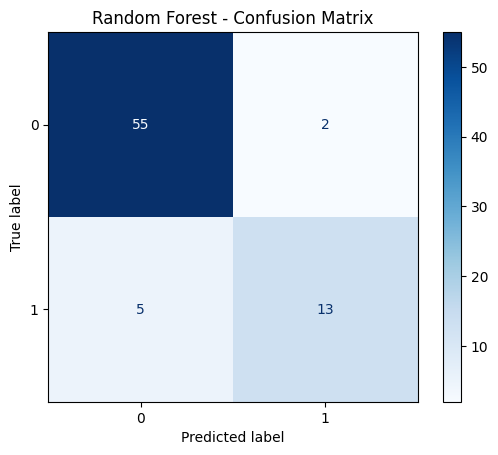


Decision Tree Accuracy: 0.8000
              precision    recall  f1-score   support

           0       0.88      0.86      0.87        57
           1       0.58      0.61      0.59        18

    accuracy                           0.80        75
   macro avg       0.73      0.74      0.73        75
weighted avg       0.80      0.80      0.80        75



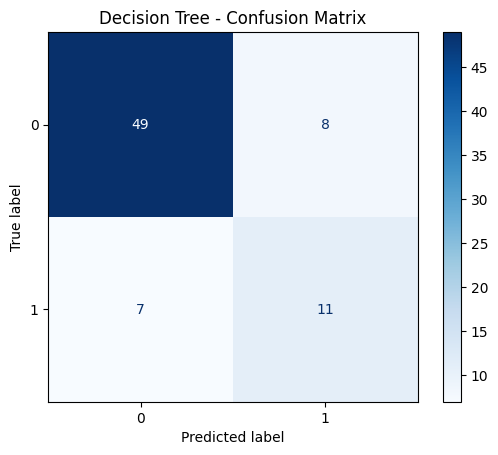


XGBoost Accuracy: 0.8667
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        57
           1       0.72      0.72      0.72        18

    accuracy                           0.87        75
   macro avg       0.82      0.82      0.82        75
weighted avg       0.87      0.87      0.87        75



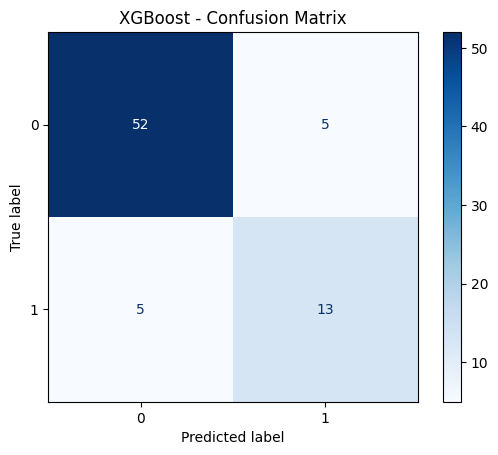


SVM Accuracy: 0.8933
              precision    recall  f1-score   support

           0       0.90      0.96      0.93        57
           1       0.86      0.67      0.75        18

    accuracy                           0.89        75
   macro avg       0.88      0.82      0.84        75
weighted avg       0.89      0.89      0.89        75



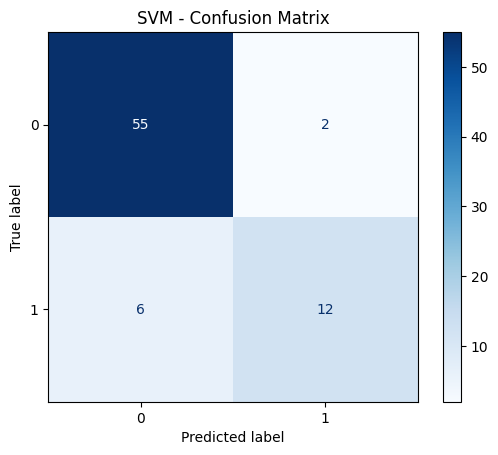


Naive Bayes Accuracy: 0.8933
              precision    recall  f1-score   support

           0       0.90      0.96      0.93        57
           1       0.86      0.67      0.75        18

    accuracy                           0.89        75
   macro avg       0.88      0.82      0.84        75
weighted avg       0.89      0.89      0.89        75



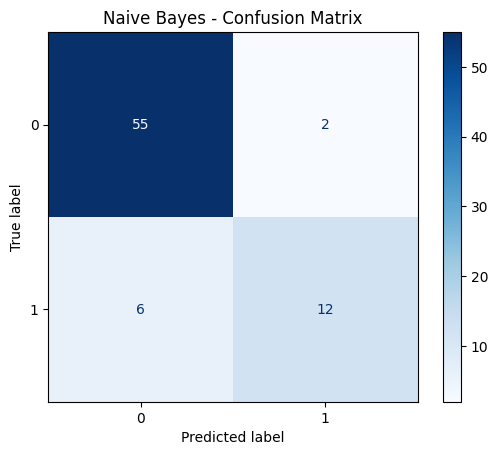

In [21]:
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc

    print(f"\n{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))

    # عرض مصفوفة الالتباس
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_ if hasattr(model, 'classes_') else [0,1])
    disp.plot(cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


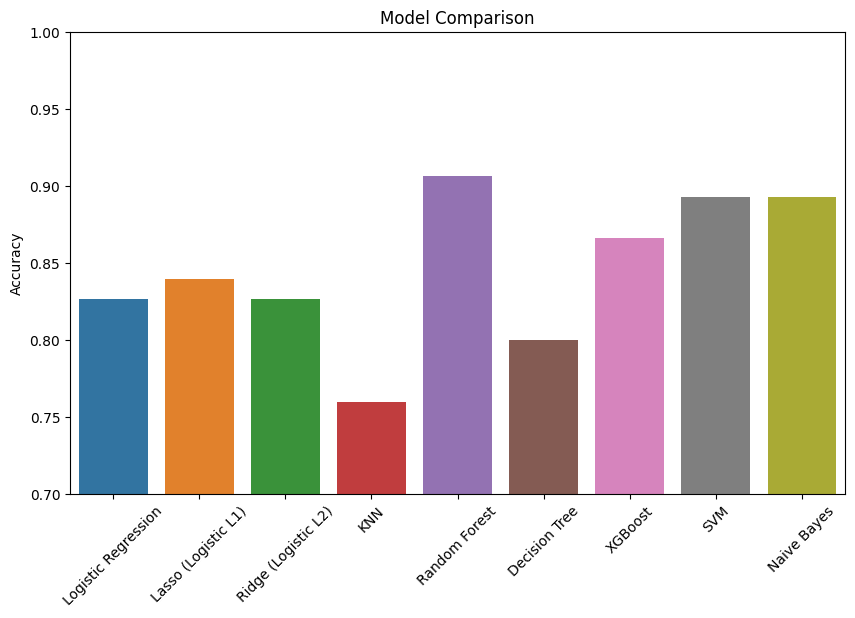

In [22]:
plt.figure(figsize=(10,6))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.xticks(rotation=45)
plt.ylabel("Accuracy")
plt.title("Model Comparison")
plt.ylim(0.7, 1.0)
plt.show()

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [24]:
# Define the model
model = keras.Sequential()
model.add(keras.layers.Dense(32,  activation="relu", input_shape = X_train.shape[1:]))
model.add(keras.layers.Dense(16, activation="relu"))
model.add(keras.layers.Dense(1, activation="sigmoid"))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-09 21:37:52.632676: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [25]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.4679 - loss: 0.7775 - val_accuracy: 0.5333 - val_loss: 0.6776
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4824 - loss: 0.7511 - val_accuracy: 0.5778 - val_loss: 0.6504
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4679 - loss: 0.7262 - val_accuracy: 0.6889 - val_loss: 0.6273
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4863 - loss: 0.7053 - val_accuracy: 0.7111 - val_loss: 0.6073
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5042 - loss: 0.6797 - val_accuracy: 0.7333 - val_loss: 0.5895
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5402 - loss: 0.6703 - val_accuracy: 0.6889 - val_loss: 0.5735
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5701 - loss: 0.6490 - val_accuracy: 0.7333 - val_loss: 0.5601
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5712 - loss: 0.6431 - val_accuracy: 0.7333 - val_loss

In [27]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32,
                          validation_split=0.2, callbacks=[early_stop], verbose=0)

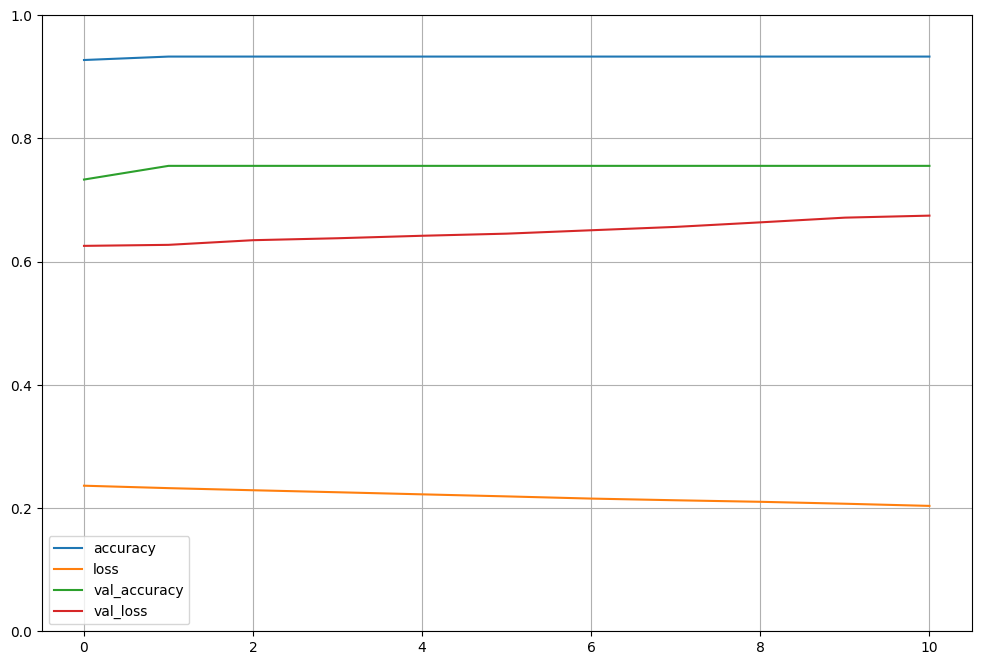

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8904 - loss: 0.3173 
Loss     :  0.3523319959640503
accuracy :  0.8666666746139526


In [28]:
# Plot the learning curves

pd.DataFrame(history.history).plot(figsize=(12, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

# Evaluate the model
model_evaluate = model.evaluate(X_test, y_test)
print("Loss     : ",model_evaluate[0])
print("accuracy : ",model_evaluate[1])

In [29]:


# التقييم
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Keras Neural Network Accuracy: {acc:.4f}")
results['Keras Neural Network'] = acc

Keras Neural Network Accuracy: 0.8667


In [30]:
import pickle

In [31]:

file_name='Heart_Failure.sav'
pickle.dump(models['Random Forest'],open(file_name,'wb'))

In [32]:
import joblib
joblib.dump(models['Random Forest']
            , "model.pkl")
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']